[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alexj-smolin/ds-school/blob/main/part4/HW1.ipynb)

In [1]:
import numpy as np
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks", {'axes.grid': True})

## Task 1

In [2]:
class SimpleNN(nn.Module):
    def __init__(self, in_feat, hid_feat, out_feat):
        super().__init__()
        
        self.lin1 = nn.Linear(in_feat, hid_feat)
        self.lin2 = nn.Linear(hid_feat, hid_feat)
        self.lin3 = nn.Linear(hid_feat, out_feat)
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        x = self.act(self.lin1(x))
        x = self.act(self.lin2(x))
        x = self.lin3(x)
        return x

In [3]:
X = torch.randn((100, 2))

model = SimpleNN(2, 10, 1)

In [4]:
y = model(X)

In [5]:
def show_grad_fn(root, indent=0):
    print(f'{" " * indent}{root}')
    if root == None: return
    for child, _ in root.next_functions:
        show_grad_fn(child, indent + 4)

show_grad_fn(y.grad_fn)

                    None


Выше представлен граф вычислений для сетки.
Сверху вниз объекты `AddmmBackward0` предоставляют градиенты для слоев lin3 -> lin2 -> lin1 (разворачиваем граф вычислений в обратном порядке). Объекты `SigmoidBackward0` - градиенты для функции активации

## Task 2

Реализуем оптимизатор Adam по алгоритму из лекции и используем его для поиска минимума квадратичной функции

In [6]:
def q_func(a, b, c):
    return lambda x: a * x ** 2 + b * x + c

f = q_func(1, -8, 7)
x = torch.linspace(0, 8, 200)

# функция имеет минимум в точке x=4

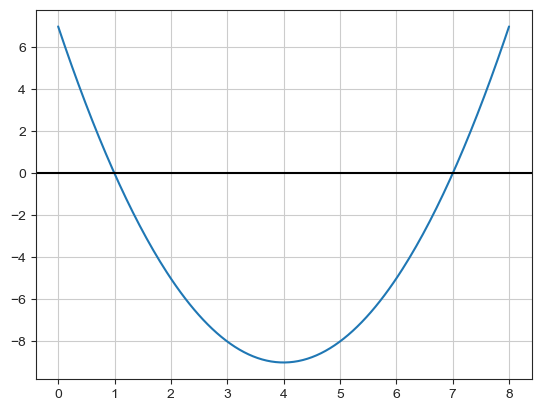

In [7]:
sns.lineplot(x=x, y=f(x))\
   .axhline(0, c='k');

In [8]:
class Adam:
    def __init__(self, param, lr, beta1=0.9, beta2=0.999):
        self.param = param
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.velocity = 0.
        self.accum = 0.

    def zero_grad(self):
        if self.param.grad: self.param.grad.zero_()

    def step(self):
        grad = self.param.grad.data
        self.velocity = self.beta1 * self.velocity + (1 - self.beta1) * grad
        self.accum = self.beta2 * self.accum + (1 - self.beta2) * grad ** 2
        adapt_lr = self.lr / self.accum.sqrt()
        self.param.data -= adapt_lr * self.velocity

In [9]:
def find_min(x_start, func, optim_sup, lr=0.1, max_steps=200):
    x = torch.tensor(x_start, requires_grad=True)
    v = [x.item()]
    optim = optim_sup(x, lr)
    for _ in range(max_steps):
        # forward
        y = func(x)

        # backward
        optim.zero_grad()
        y.backward()

        # optim
        optim.step()

        v.append(x.item())
    return v[-1], v

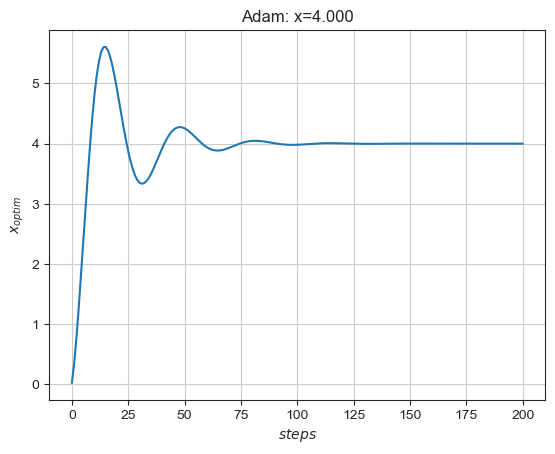

In [10]:
x_min, hist = find_min(np.random.randn(), f, Adam, lr=0.1)
sns.lineplot(x=range(len(hist)), y=hist)\
   .set(title=f'Adam: x={x_min:.3f}', xlabel='$steps$', ylabel='$x_{optim}$');

Видно, что оптимизатор довольно долго сходится, причем несколько раз перескакивает через минимум

## Task 3

Возьмем функцию из предыдущей задачи. Ее корни равны 1 и 7. Чтобы найти их с помощью градиентного спуска, избавимся от отрицательных значений с помощью одного из преобразований: abs(x) или x^2. Тогда отрицательные значения станут положительными, а нули будут наименьшими значениями новой функции. После этого можно применить градиентный спуск для поиска этих минимумов

In [11]:
def f_abs(func):
    return lambda x: func(x).abs()

def f_quad(func):
    return lambda x: func(x) ** 2

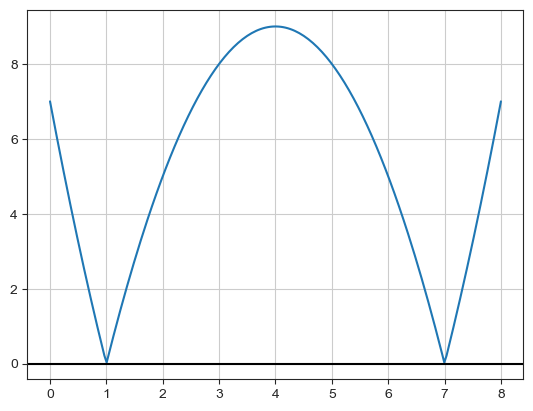

In [12]:
sns.lineplot(x=x, y=f_abs(f)(x))\
   .axhline(0, c='k');

In [13]:
class GradientDescent:
    def __init__(self, param, lr):
        self.param = param
        self.lr = lr

    def zero_grad(self):
        if self.param.grad: self.param.grad.zero_()

    def step(self):
        self.param.data -= self.lr * self.param.grad.data

Найдем сначала минимум исходной функции. После преобразования он будет локальным максимумом преобразованной функции. Если выбрать начальную точку для поиска минимума преобразованной функции с некоторым отступом в каждую сторону от найденной точки, то можно сразу найти оба корня исходной функции

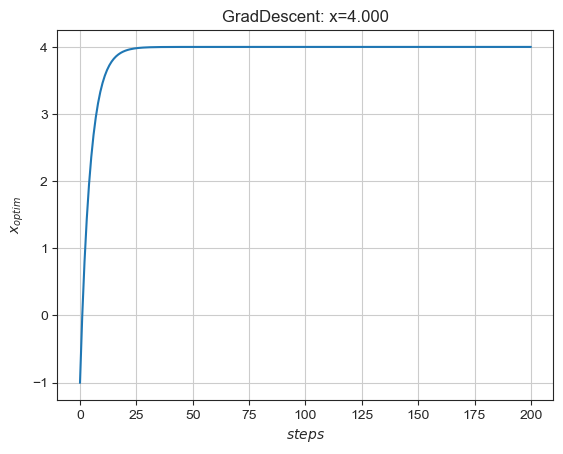

In [14]:
x_start = np.random.randn() # т.к. минимум у нашей параболы единственный, то выберем начальную точку случайно

x_min, hist = find_min(x_start, f, GradientDescent, lr=0.1)
sns.lineplot(x=range(len(hist)), y=hist)\
   .set(title=f'GradDescent: x={x_min:.3f}', xlabel='$steps$', ylabel='$x_{optim}$');

Обычный градиентый спуск нашел минимум гораздо быстрее чем Adam при том же learningRate.

Далее отступим в обе стороны от найденного значения x_min и снова запустим градиентный спуск на преобразованной функции

In [15]:
d = 10. # отступ, чем больше мы доверяем найденному минимуму, тем меньше можно делать этот отступ :)

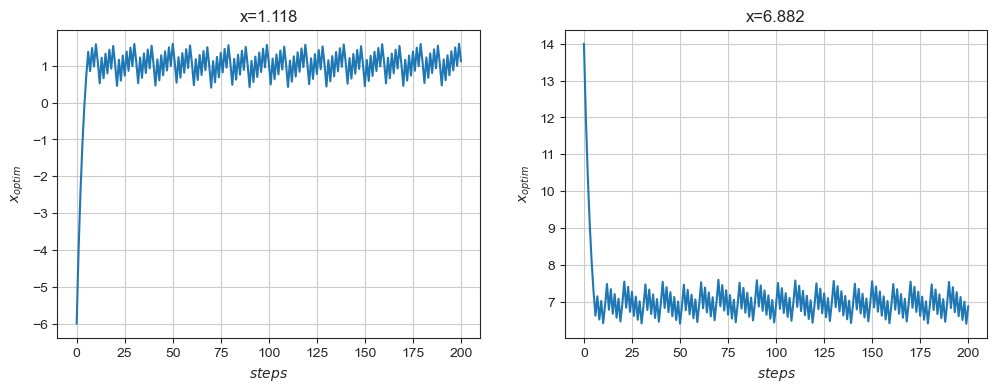

In [16]:
x_root1, hist1 = find_min(x_min - d, f_abs(f), GradientDescent, lr=0.1)
x_root2, hist2 = find_min(x_min + d, f_abs(f), GradientDescent, lr=0.1)

_, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(x=range(len(hist1)), y=hist1, ax=ax[0])
ax[0].set(title=f'x={x_root1:.3f}', xlabel='$steps$', ylabel='$x_{optim}$')

sns.lineplot(x=range(len(hist2)), y=hist2, ax=ax[1])
ax[1].set(title=f'x={x_root2:.3f}', xlabel='$steps$', ylabel='$x_{optim}$');

Довольно близко, но не идеально. Из-за слишком острого угла в месте перегиба преобразованной функции и большого learningRate не получается спуститься ниже некоторого уровня. Попробуем Adam!

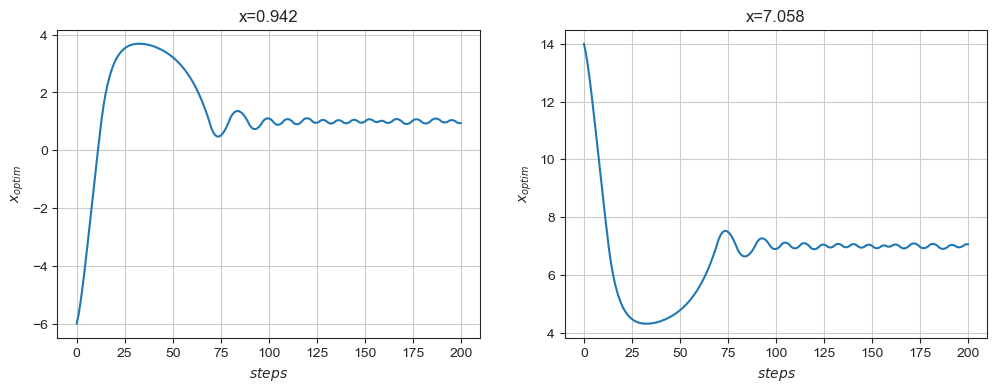

In [17]:
x_root1, hist1 = find_min(x_min - d, f_abs(f), Adam, lr=0.1)
x_root2, hist2 = find_min(x_min + d, f_abs(f), Adam, lr=0.1)

_, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(x=range(len(hist1)), y=hist1, ax=ax[0])
ax[0].set(title=f'x={x_root1:.3f}', xlabel='$steps$', ylabel='$x_{optim}$')

sns.lineplot(x=range(len(hist2)), y=hist2, ax=ax[1])
ax[1].set(title=f'x={x_root2:.3f}', xlabel='$steps$', ylabel='$x_{optim}$');

Стало немного лучше, но все равно при достижении некоторой окрестности минимума начинается осцилляция. Есть еще вариант воспользоваться вторым преобразованием с возведением функции в квадрат. Возможно приблизимся к минимуму еще сильнее, т.к. в местах перегиба функция гладкая и ее производная уменьшается. Это поможет уменьшить шаги градиентного спуска при приближении к оптимуму 

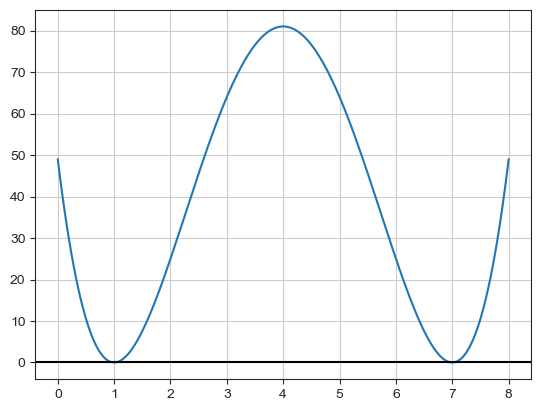

In [18]:
# График функции, возведенной в квадрат

sns.lineplot(x=x, y=f_quad(f)(x))\
   .axhline(0, c='k');

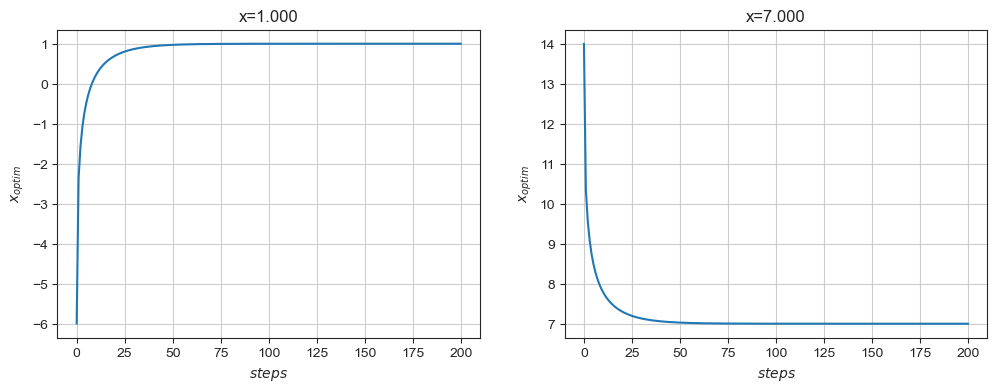

In [19]:
x_root1, hist1 = find_min(x_min - d, f_quad(f), GradientDescent, lr=0.001)
x_root2, hist2 = find_min(x_min + d, f_quad(f), GradientDescent, lr=0.001)

_, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(x=range(len(hist1)), y=hist1, ax=ax[0])
ax[0].set(title=f'x={x_root1:.3f}', xlabel='$steps$', ylabel='$x_{optim}$')

sns.lineplot(x=range(len(hist2)), y=hist2, ax=ax[1])
ax[1].set(title=f'x={x_root2:.3f}', xlabel='$steps$', ylabel='$x_{optim}$');

Со значением learningRate = 0.1 градиентный спуск не сходится. Но после уменьшения этого параметра результат получился практически идеальным.

В примерах выше с преобразованием abs() и оптимизаторами GradientDescent и Adam можно также добиться идеальных результатов при уменьшении learningRate